In [1]:
# Cell 1: Imports and Setup
import torch
import torchaudio
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import logging
import os
from tqdm import tqdm

# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Set up paths
DATA_DIR = Path('data')
RAW_DIR = DATA_DIR / 'raw' / 'test-clean'
PROCESSED_DIR = DATA_DIR / 'processed' / 'test-clean'

# Create directories if they don't exist
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)
(PROCESSED_DIR / 'spectrograms').mkdir(exist_ok=True)
(PROCESSED_DIR / 'waveforms').mkdir(exist_ok=True)

In [2]:
# Cell 2: Processing Functions
def process_audio_file(audio_path, sample_rate=16000):
    """Process a single audio file."""
    try:
        # Load audio
        waveform, sr = torchaudio.load(audio_path)
        
        # Resample if necessary
        if sr != sample_rate:
            resampler = torchaudio.transforms.Resample(sr, sample_rate)
            waveform = resampler(waveform)
        
        # Convert to mel spectrogram
        mel_transform = torchaudio.transforms.MelSpectrogram(
            sample_rate=sample_rate,
            n_fft=1024,
            hop_length=256,
            n_mels=80
        )
        mel_spec = mel_transform(waveform)
        
        return waveform, mel_spec, True
        
    except Exception as e:
        logger.error(f"Error processing {audio_path}: {str(e)}")
        return None, None, False

def plot_audio(waveform, mel_spec, title=""):
    """Plot waveform and spectrogram."""
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
    
    # Plot waveform
    waveform_np = waveform[0].detach().cpu().numpy()  # Convert to numpy array
    ax1.plot(waveform_np)
    ax1.set_title(f"{title} - Waveform")
    ax1.set_xlabel("Sample")
    ax1.set_ylabel("Amplitude")
    
    # Plot spectrogram
    mel_spec_np = mel_spec[0].detach().cpu().numpy()  # Convert to numpy array
    ax2.imshow(np.log2(mel_spec_np), aspect='auto', origin='lower')
    ax2.set_title(f"{title} - Mel Spectrogram")
    ax2.set_xlabel("Frame")
    ax2.set_ylabel("Frequency Bin")
    plt.colorbar(ax2.images[0], ax=ax2, format='%+2.0f dB')
    
    plt.tight_layout()
    plt.show()

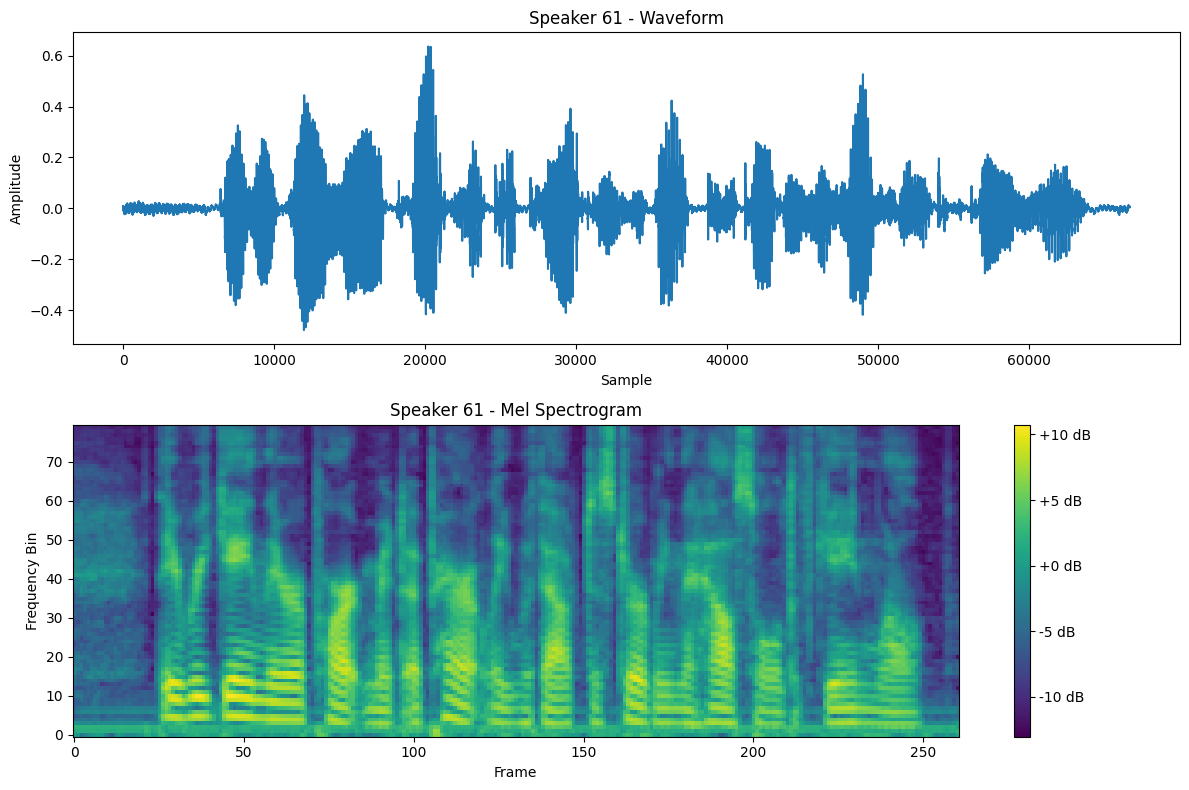

Sample rate: 16000 Hz
Waveform shape: torch.Size([1, 66640])
Mel spectrogram shape: torch.Size([1, 80, 261])


In [3]:
# Cell 3: Process and Visualize a Sample
# Get the first FLAC file (nested in speaker/chapter directories)
audio_files = list(RAW_DIR.glob('**/*.flac'))
if audio_files:
    audio_path = audio_files[0]
    speaker_id = audio_path.parent.parent.name  # Get speaker ID from grandparent directory
    
    # Process the file
    waveform, mel_spec, success = process_audio_file(audio_path)
    
    if success:
        # Plot the results
        plot_audio(waveform, mel_spec, f"Speaker {speaker_id}")
        
        # Print some information
        print(f"Sample rate: {16000} Hz")
        print(f"Waveform shape: {waveform.shape}")
        print(f"Mel spectrogram shape: {mel_spec.shape}")
    else:
        print("Failed to process audio file")
else:
    print("No FLAC files found in the directory")

In [4]:
# Cell 4: Process Entire Dataset
def process_dataset():
    """Process all audio files in the dataset."""
    logger.info("Starting dataset processing...")
    
    # Get all audio files (recursively)
    audio_files = list(RAW_DIR.glob('**/*.flac'))
    logger.info(f"Found {len(audio_files)} audio files to process")
    
    # Process each file
    success_count = 0
    for audio_path in tqdm(audio_files):
        # Extract speaker ID from path
        speaker_id = audio_path.parent.parent.name
        
        # Process the file
        waveform, mel_spec, success = process_audio_file(audio_path)
        
        if success:
            # Save processed files
            base_name = f"{speaker_id}_{audio_path.stem}"
            
            # Save mel spectrogram
            spec_path = PROCESSED_DIR / 'spectrograms' / f"{base_name}_mel.pt"
            torch.save(mel_spec, spec_path)
            
            # Save waveform
            wave_path = PROCESSED_DIR / 'waveforms' / f"{base_name}_wave.pt"
            torch.save(waveform, wave_path)
            
            success_count += 1
    
    logger.info(f"Processing complete. Successfully processed {success_count}/{len(audio_files)} files")

# Run the processing
process_dataset()

INFO:__main__:Starting dataset processing...
INFO:__main__:Found 2620 audio files to process
100%|██████████| 2620/2620 [00:12<00:00, 210.81it/s]
INFO:__main__:Processing complete. Successfully processed 2620/2620 files
